<div style="width: 30%; float: right; margin: 10px; margin-right: 5%;">
    <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/d/d3/FHNW_Logo.svg/2560px-FHNW_Logo.svg.png" width="500" style="float: left; filter: invert(50%);"/>
</div>

<h1 style="text-align: left; margin-top: 10px; float: left; width: 60%;">
    npr Mini-Challenge 1: <br>EDA & Preprocessing
</h1>

<p style="clear: both; text-align: left;">
    Bearbeitet durch Florin Barbisch, Gabriel Torres Gamez und Jan Zwicky im HS 2023.
</p>

## Vorgegebenes Ziel

Wir evaluieren 3 verschiedene Klassifikationssysteme in einer Textklassifikationsaufgabe. <br><br>
Wir argumentieren, warum wir diese Systeme für diesen Fall ausgewählt haben, und bauen, trainieren und bewerten das System. <br><br>
Wir führen auch eine gründliche Fehleranalyse durch und schlagen Theorien zur Verbesserung der Systeme vor, <br>
insbesondere durch die Analyse einzelner Fälle und den Vergleich der Vorhersagen jedes Systems. <br>
Mindestens eines der Systeme basiert auf einem feinabgestimmten Deep-Learning-Modell.

Hier können wir Daten aus gemeinsamen Aufgaben verwenden, wie zum Beispiel Semeval, Kaggle, <br>Codalab oder Paperwithcode für die Textklassifikation.

## Requirements, Imports und Einstellungen
Hier werden die benötigten Python-Pakete importiert und die Einstellungen für die Plots
vorgenommen. 

In [1]:
# All Imports
import sys
import html
import string
import sklearn
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Versions of the packages used
print(f"Python Version: {sys.version}")
print(f"Numpy Version: {np.__version__}")
print(f"Pandas Version: {pd.__version__}")
print(f"Matplotlib Version: {plt.matplotlib.__version__}")
print(f"Sklearn Version: {sklearn.__version__}")
print(f"Seaborn Version: {sns.__version__}")

# Warnings Settings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

# Numpy Settings
np.set_printoptions(precision=2, suppress=True)
np.random.seed(42)

# Matplotlib Settings
plt.rcParams["figure.figsize"] = (24, 12)

Python Version: 3.10.13 (main, Aug 24 2023, 12:59:26) [Clang 15.0.0 (clang-1500.0.40.1)]
Numpy Version: 1.23.5
Pandas Version: 2.1.1
Matplotlib Version: 3.6.3
Sklearn Version: 1.3.1
Seaborn Version: 0.12.2


## Helper Functions

Hier werden Funktionen definiert, die bei beiden Modellen verwendet werden.

In [2]:
# Metrics, shortcuts, constants, etc.

## Gewählter Datensatz

Wir haben uns für den <a href="https://www.kaggle.com/competitions/nlp-getting-started/data">"Natural Language Processing with Disaster Tweets"</a> Datensatz entschieden.<br><br>
Der Datensatz passt zum Ziel der Mini Challenge, da er Textdaten aus Twitter enthält, die in Notfällen <br>als wichtiger Kommunikationskanal dienen. Dies ermöglicht die Entwicklung und Evaluierung von <br>Textklassifikationssystemen, um Tweets zu identifizieren, die echte Katastrophen ankündigen, <br>von solchen, die dies nicht tun. <br><br>Dies erfordert eine gründliche Fehleranalyse und die Entwicklung von Modellen, die in der Lage sind, <br>die Bedeutung von Wörtern und Ausdrücken im Kontext zu verstehen, da Tweets oft metaphorische <br>Sprache verwenden können. <br><br>Wir haben Zugriff auf einen Datensatz von 10.000 handklassifizierten Tweets, der eine solide <br>Grundlage für die Evaluierung und Verbesserung von Textklassifikationssystemen bietet.

## Explorative Datenanalyse

In [3]:
tweets = pd.read_csv("./data/raw/train.csv", index_col="id", encoding="utf-8")
tweets.columns

Index(['keyword', 'location', 'text', 'target'], dtype='object')

Der Datensatz hat zum Text und dem Target noch die Spalten Keyword und Location. Diese werden wir für die Klassifikation nicht verwenden. Ein hybrides Modell könnte die Vorhersage verbessern.

In [4]:
tweets = tweets.loc[:,["text","target"]]

Damit wir keinen Leak von Trainingsdaten in die Testdaten haben müssen wir den Datensatz auf Duplikate überprüfen und allfällige Duplikate entfernen.

In [5]:
print(f"Anzahl doppelte Werte: {tweets['text'].duplicated().sum()}")

Anzahl doppelte Werte: 110


Wir entfernen alle Duplikate und fügen nur die hinzu, welche sich beim Target einig sind.

In [6]:

unique_tweets, duplicates = (
    tweets.drop_duplicates(subset=["text"], keep=False),
    tweets[tweets["text"].duplicated(keep=False)] \
        .groupby(["text", "target"]).size().reset_index().rename(columns={0: "count"})
)

contradicting_duplicates, agreeing_duplicates = (
    duplicates[duplicates["text"].duplicated(keep=False)],
    duplicates[~duplicates["text"].duplicated(keep=False)]
)
tweets = pd.concat([unique_tweets, agreeing_duplicates.drop_duplicates(subset=["text"])]).loc[:, ["text", "target"]]

Im nächsten Schritt wird ein Trainings- und Testset erstellt. Dies wird zu diesem Zeitpunkt gemacht, damit wir keine Informationen über das Testset gewinnen.

In [7]:
train, val = train_test_split(tweets, test_size=0.2,random_state=10)

Im nächsten Schritt wird untersucht, ob es unbekannte oder doppelte Werte hat. 

In [8]:
print(f"Anzahl NA Werte: {train.isna().any().sum()}")
print(f"Anzahl doppelte Werte: {train['text'].duplicated().sum()}")

Anzahl NA Werte: 0
Anzahl doppelte Werte: 0


Es hat keine NA Werte und logischerweise auch keine doppelte Werte mehr.

Als Target sind die Erwarteten Werte vorhanden.

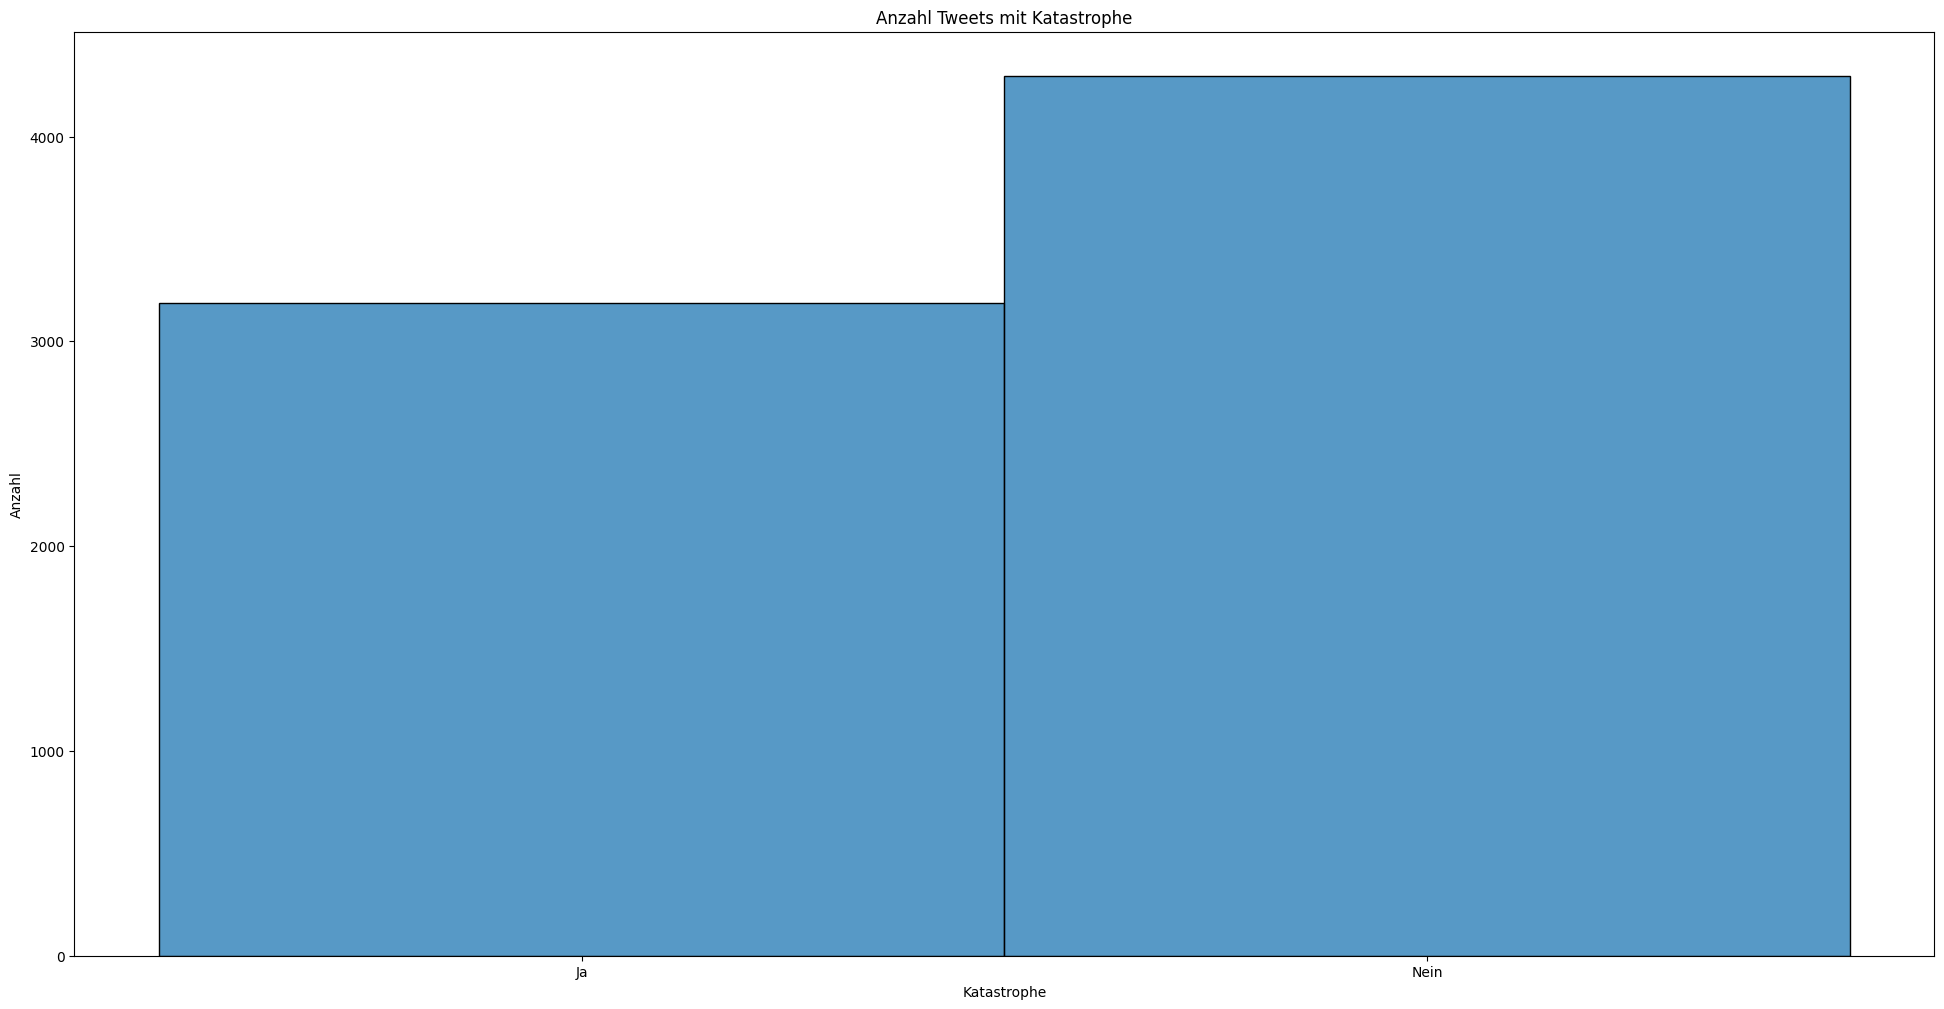

In [9]:
sns.histplot(tweets["target"].replace({0:"Nein",1:"Ja"}))
plt.title("Anzahl Tweets mit Katastrophe")
plt.ylabel("Anzahl")
plt.xlabel("Katastrophe")
plt.show()

Es hat nicht gleiche viele Tweets von beiden Klassen. Dies hat einen Einfluss auf die Metrik, die ausgewählt wird.

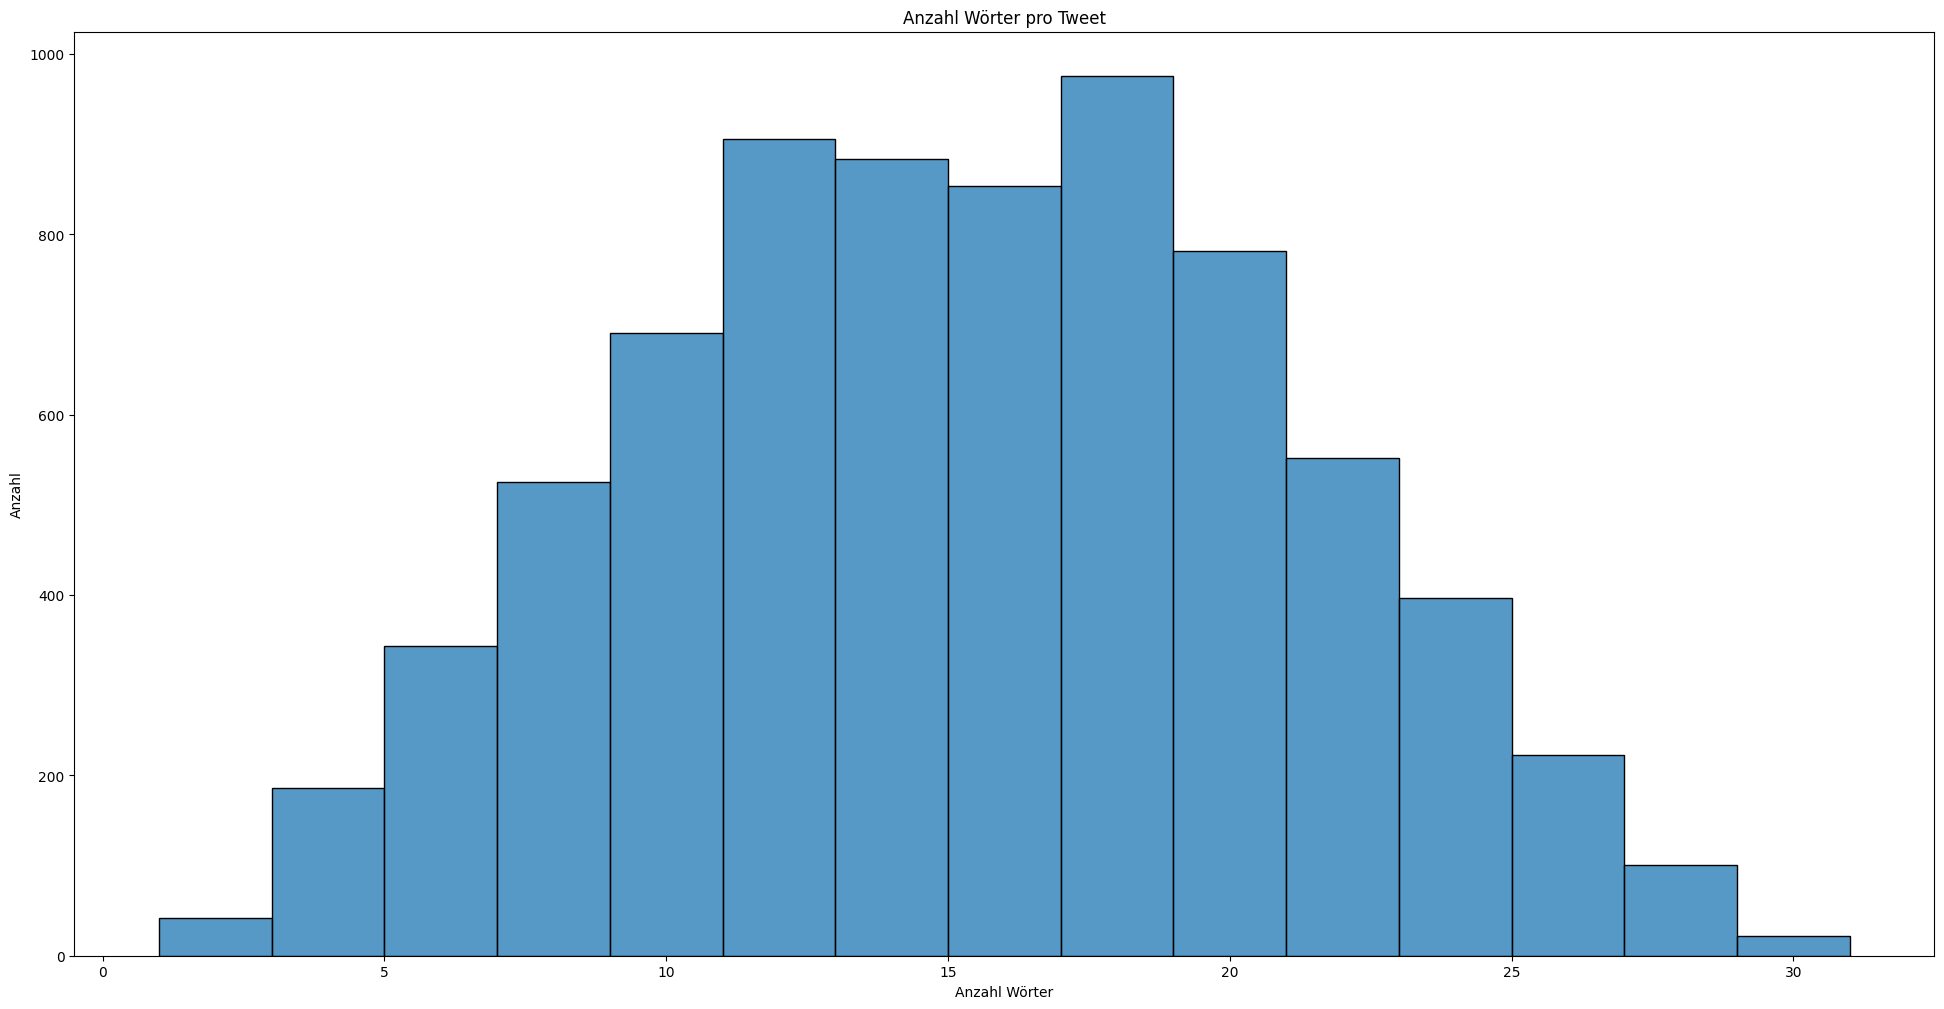

In [10]:
# plot the average number of words per tweet
sns.histplot(tweets["text"].str.split().apply(len), bins=15)
plt.title("Anzahl Wörter pro Tweet")
plt.ylabel("Anzahl")
plt.xlabel("Anzahl Wörter")
plt.show()

Die meisten Tweets haben zwischen 10 und 20 Wörter. Nur die wenigsten haben mehr als 30 Wörter oder weniger als 5 Wörter. Bei kürzeren Tweets könnte das Modell Schwierigkeiten haben.

### TF-IDF

TF-IDF (Term Frequency-Inverse Document Frequency) ist eine Textanalyse-Technik, die die Bedeutung von Wörtern in einem Dokument anhand ihrer Häufigkeit und Seltenheit in einem Textkorpus ermittelt. Sie wird häufig in Information Retrieval und Text-Mining verwendet.

Hier werden wir die wichtigsten Wörter für Tweets mit Katastrophen und ohne Katastrophen ermitteln. Dies kann uns helfen, die Daten besser zu verstehen und die Modelle zu verbessern.

In [11]:
# quick preprocessing, remove special characters
catastrophe_tweets = [html.unescape(tweet) for tweet in tweets[tweets.target == 1]["text"]]
catastrophe_tweets = [
    tweet.translate(str.maketrans("", "", string.punctuation)) for tweet in catastrophe_tweets
]

normal_tweets = [html.unescape(tweet) for tweet in tweets[tweets.target == 0]["text"]]
normal_tweets = [
    tweet.translate(str.maketrans("", "", string.punctuation)) for tweet in normal_tweets
]

all_tweets = catastrophe_tweets + normal_tweets

display("Example tweets:")
display(all_tweets[:10])

'Example tweets:'

['Our Deeds are the Reason of this earthquake May ALLAH Forgive us all',
 'Forest fire near La Ronge Sask Canada',
 'All residents asked to shelter in place are being notified by officers No other evacuation or shelter in place orders are expected',
 '13000 people receive wildfires evacuation orders in California ',
 'Just got sent this photo from Ruby Alaska as smoke from wildfires pours into a school ',
 'RockyFire Update  California Hwy 20 closed in both directions due to Lake County fire  CAfire wildfires',
 'flood disaster Heavy rain causes flash flooding of streets in Manitou Colorado Springs areas',
 'Im on top of the hill and I can see a fire in the woods',
 'Theres an emergency evacuation happening now in the building across the street',
 'Im afraid that the tornado is coming to our area']

Für die TF-IDF Analyse haben wir spezielle HTML Charaktere in richtige Charaktere umgewandelt, um keine Artefakte wie &amp als Wort zu erhalten. Da wir bei der Wichtigkeit der Wörter nicht Hashtags, Mentions, Satzendungen, Nebensätze etc. haben wollen und uns nur die Wörter interessieren, haben wir daraufhin alle Sonderzeichen entfernt.

Hier sehen wir, dass die Tweets korrekt bereinigt wurden.

In [12]:
# Load the english stop words
stop_words_en = (
    pd.read_csv(
        "https://raw.githubusercontent.com/stopwords-iso/stopwords-en/master/stopwords-en.txt",
        header=None,
    )
    .iloc[:, 0]
)
stop_words_en = [word for word in stop_words_en if isinstance(word, str)]

# Create the tfidf matrix
tfidf = TfidfVectorizer(stop_words=stop_words_en, strip_accents="unicode", lowercase=True)
tfidf_matrix = tfidf.fit_transform(all_tweets)
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())

# Results
print(f"Top 10 Catastrophe Tweets Features: \n{tfidf_df.iloc[:len(catastrophe_tweets)].mean().sort_values(ascending=False)[:10]}\n")
print(f"Top 10 Normal Tweets Features: \n{tfidf_df.iloc[len(catastrophe_tweets):].mean().sort_values(ascending=False)[:10]}")

Top 10 Catastrophe Tweets Features: 
news          0.008654
california    0.008367
disaster      0.007810
suicide       0.007424
hiroshima     0.006959
fires         0.006683
people        0.006676
police        0.006583
killed        0.006509
families      0.006466
dtype: float64

Top 10 Normal Tweets Features: 
body         0.006154
love         0.005866
time         0.004967
people       0.004865
day          0.004827
video        0.004752
lol          0.004318
youtube      0.004133
life         0.003966
emergency    0.003872
dtype: float64


Als nächstes haben wir unser TF-IDF Modell trainiert. Da die integrierte Stopwords Liste sehr klein ist und viele Stopwords nicht herausgefilter hat, nehmen wir eine grössere Liste aus dem Internet. Akzente wurden herausgenommen und alle Wörter werden in Kleinbuchstaben umgewandelt, da TF-IDF diese sonst als verschiedene Wörter klassifizieren könnte.

Wir können erkennen, dass negativere Wörter häufig wichtige Wörter für Tweets mit Katastrophen sind. 
Dies ist bei Tweets ohne Katastrophen nicht der Fall.

### Dateiexport

In [13]:
train.sort_index().to_csv("./data/processed/train.csv", index=True, index_label="id")
val.sort_index().to_csv("./data/processed/val.csv", index=True, index_label="id")